# Obtaining Dataset 

In [5]:
# import zipfile
# with zipfile.ZipFile("dataset/BACH2018.zip","r") as zip_ref:
#     zip_ref.extractall()

# Importing Necessary Libraries

In [2]:
# First installation
# %pip install keras_applications

In [2]:
import shutil
import os
import cv2
import keras
import gc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from PIL import Image

from keras import backend as K
from keras import layers
from keras.applications import ResNet50, InceptionV3, InceptionResNetV2, VGG19
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

%matplotlib inline

# Assigning Parameters
InceptionV3: 299 image size <br>
Resnet: 224 image size <br>
InceptionResnetV2: 299 image size <br>

In [3]:
IMG_SIZE = 224
# BATCH_SIZE = 32
# EPOCHS = 40

# Loading Dataset Images

In [4]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
  IMG = []
  read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
  for IMAGE_NAME in tqdm(os.listdir(DIR)):
      PATH = os.path.join(DIR,IMAGE_NAME)
      _, ftype = os.path.splitext(PATH)
      if ftype == ".tif":                        # Transfer tif images to array images 
          img = read(PATH)                       # read image path & convert to RGB
          img = cv2.resize(img, (RESIZE,RESIZE)) # resize image
          IMG.append(np.array(img))              # convert image to numpy array & append to array of images
  return IMG

# Loading the dataset for each class
benign_data = np.array(Dataset_loader('Photos/Benign',IMG_SIZE))
insitu_data = np.array(Dataset_loader('Photos/InSitu',IMG_SIZE))
invasive_data = np.array(Dataset_loader('Photos/Invasive',IMG_SIZE))
normal_data = np.array(Dataset_loader('Photos/Normal',IMG_SIZE))

100%|██████████| 101/101 [00:02<00:00, 44.34it/s]


# Creating Labels for the dataset
##### 4 Labels: Benign, InSitu, Invasive, Normal

In [5]:
# Create labels
benign_label = np.zeros(len(benign_data))
insitu_label = np.ones(len(insitu_data))
invasive_label = np.full(len(invasive_data), 2)
normal_label = np.full(len(normal_data), 3)

# Merge data
X = np.concatenate((benign_data, insitu_data, invasive_data, normal_data), axis = 0)
Y = np.concatenate((benign_label, insitu_label, invasive_label, normal_label), axis = 0)

# Shuffle data
s = np.arange(X.shape[0])
np.random.seed(1234)
np.random.shuffle(s)
X = X[s]
Y = Y[s]

# Change Y to categorical
Y = to_categorical(Y, num_classes= 4)

# Split into Train, Validation and Test datasets

In [6]:
# Training set
x_train, X_remainder, y_train, Y_remainder = train_test_split(
    X, Y, 
    train_size=0.7, 
    random_state=1234
    )
# Validation and Test set
x_val, x_test, y_val, y_test = train_test_split(
    X_remainder, Y_remainder, 
    train_size=0.5, 
    random_state=1234
    )


In [7]:
# Saving test images to be used through UI
try:
    shutil.rmtree("exported_images")
except FileNotFoundError:
    pass    
os.mkdir("exported_images")
labels = ["benign", "insitu", "invasive", "normal"]
for i in range(len(x_test)):
    data = Image.fromarray(x_test[i])
    label = labels[np.argmax(y_test[i])]
    filepath = f"exported_images/{i+1}_{label}.png"
    data.save(filepath)

# Displaying Some Images with their Labels

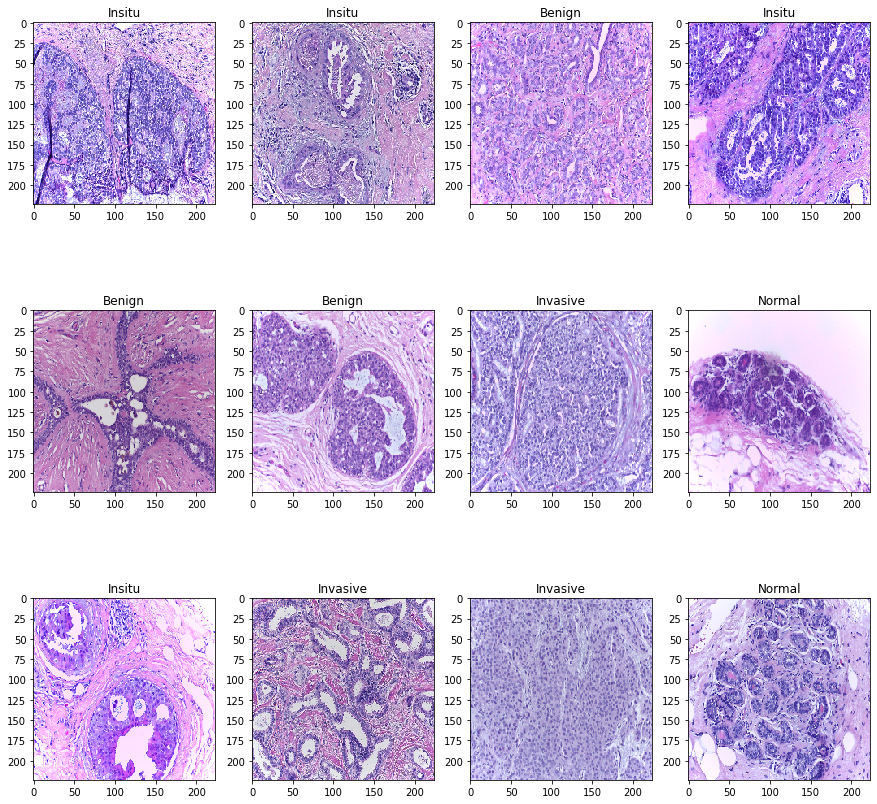

In [8]:
# Display the first 15 images and their labels
w = 60; h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    elif np.argmax(y_train[i]) == 1:
        ax.title.set_text('Insitu')
    elif np.argmax(y_train[i]) == 2:
        ax.title.set_text('Invasive')
    else:
        ax.title.set_text('Normal')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Preprocessing: Data Augmentation

In [9]:
# Using original generator for data augmentation
train_generator = ImageDataGenerator(
        zoom_range = 2,  # set range for random zoom
        rotation_range = 90, # set range for image rotation
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images 
    )

train_generator.fit(x_train)    

# CNN Model

## Building Model

In [10]:
def build_model(backbone, lr=1e-4, opt = "adam", include = False):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D(name = "final"))
    if include:
        model.add(layers.Dropout(0.5))
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(4, activation='softmax'))
    
    if opt == 'adam':
        optimizer = keras.optimizers.Adam(lr)
    elif opt == 'nadam':
        optimizer = keras.optimizers.Nadam(lr)
    elif opt == 'adagrad':
        optimizer = keras.optimizers.Adagrad(lr)
    elif opt == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(lr)
    elif opt == 'adadelta':
        optimizer = keras.optimizers.Adadelta(lr)
    else:
        optimizer = keras.optimizers.SGD(lr)    

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

In [13]:
optimizers = ["adam", "rmsprop", "nadam"]
learning_rates = [0.001, 0.0005, 0.0001]
include = [True, False]
batch_size = [16, 32]
epochs = 50

best_acc = -np.inf
for bs in batch_size:
    for lr in learning_rates:
        for inc in include:
            for opt in optimizers:
                K.clear_session()
                gc.collect()
                myModel =  ResNet50(
                    weights='imagenet',
                    include_top=False,
                    input_shape=(IMG_SIZE,IMG_SIZE,3)
                )

                model = build_model(myModel, lr = lr, opt = opt, include = inc)

                # Learning Rate Reducer
                learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                                verbose=0,factor=0.2, min_lr=1e-7)

                # Early stopping
                early_checkpoint = EarlyStopping(patience = 10, monitor = 'val_accuracy', mode = "max")           

                # Checkpoint
                filepath="weights/weights.ResNet50.hdf5" # can save to a specific folder
                checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
                
                print(f"Batch_size: {bs}, lr: {lr}, include: {inc}, optimizer: {opt}")
                history = model.fit(
                    train_generator.flow(x_train, y_train, batch_size=bs), 
                    steps_per_epoch=x_train.shape[0] / bs,      
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[learn_control, checkpoint, early_checkpoint],
                    verbose=0) 

                model.load_weights("weights/weights.ResNet50.hdf5") # load the best checkpoint weights
                y_pred = model.predict(x_test)   
                precision = precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="macro") 
                accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)) 
                recall = recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="macro") 
                f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="macro") 

                print(f"\taccuracy: {accuracy}, precision: {precision}, recall: {recall}, f1-score: {f1}")
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_history = history
                    best_model = model
                    best_bs = bs
                    best_lr = lr
                    best_inc = inc
                    best_opt = opt

print(f"Best model is with batch size: {best_bs}, learning rate: {best_lr}, include: {best_inc}, optimizer: {best_opt}")         

path="saved_model/ResNet50"
keras.models.save_model(best_model, path)          

2022-10-13 23:58:47.176767: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_2 in the registry.
Traceback (most recent call last):

  File "/home/student/miniconda3/envs/mds5/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_2 in the registry.


2022-10-13 23:58:47.176864: W tensorflow/core/kernels/data/generator_dataset_op.cc:108] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_2 in the registry.
Traceback (most recent call last):

  File "/home/student/miniconda3/envs/mds5/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=p

Batch_size: 16, lr: 0.001, include: True, optimizer: adam
2/2 [==============================] - 2s 533ms/step
	accuracy: 0.18333333333333332, precision: 0.04583333333333333, recall: 0.25, f1-score: 0.07746478873239436


/home/student/miniconda3/envs/mds5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch_size: 16, lr: 0.001, include: True, optimizer: rmsprop


KeyboardInterrupt: 